In [1]:
!pip install torch torchvision torchaudio

In [3]:
!pip install opacus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.9/239.9 kB 9.0 MB/s eta 0:00:00


In [4]:
import warnings
warnings.simplefilter("ignore")

#MAX_GRAD_NORM = 1.2
EPSILON = 3.0
DELTA = 1e-5
EPOCHS = 50

#Adaptive Clipping
initial_clip_norm = 1.0
eta_C = 0.2  # Learning rate for updating the clipping norm
target_quantile = 0.5  # Target quantile, e.g., 0.5 for the median

LR = 0.5

PATIENCE_VAL = 2
LR_FACTOR = 0.5

In [5]:
BATCH_SIZE = 4096
MAX_PHYSICAL_BATCH_SIZE = 128

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

# These values, specific to the CIFAR10 dataset, are assumed to be known.
# If necessary, they can be computed with modest privacy budgets.
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD_DEV = (0.2023, 0.1994, 0.2010)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD_DEV),
])

In [7]:
from torchvision.datasets import CIFAR10

DATA_ROOT = '../cifar10'

train_dataset = CIFAR10(
    root=DATA_ROOT, train=True, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
)

test_dataset = CIFAR10(
    root=DATA_ROOT, train=False, download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

100%|██████████| 170M/170M [00:08<00:00, 20.7MB/s]


Extracting ../cifar10/cifar-10-python.tar.gz to ../cifar10
Files already downloaded and verified


### **ResNet20 (with Adaptive Clipping)**

In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class WSConv2d(nn.Conv2d):
    def forward(self, x):
        # Weight standardization
        mean = self.weight.mean(dim=[1, 2, 3], keepdim=True)
        std = self.weight.std(dim=[1, 2, 3], keepdim=True)
        weight_standardized = (self.weight - mean) / (std + 1e-5)

        return F.conv2d(x, weight_standardized, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, num_groups=32):
        super(BasicBlock, self).__init__()
        #self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False) #First convolutional layer
        self.conv1 = WSConv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False) #First weight-standardized convolutional layer
        self.gn1 = nn.GroupNorm(num_groups, out_channels)  #GroupNorm for DP compatability

        #self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)  #Second convolutional layer
        self.conv2 = WSConv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False) #Second weight-standardized convolutional layer
        self.gn2 = nn.GroupNorm(num_groups, out_channels)  #GroupNorm for DP compatability
        # Skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                #nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                WSConv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.GroupNorm(num_groups, out_channels)  #GroupNorm for DP compatability
            )

    def forward(self, x):
        out = F.relu(self.gn1(self.conv1(x)))
        out = self.gn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet20(nn.Module):
    def __init__(self, num_classes=10, num_groups=32):
        super(ResNet20, self).__init__()
        self.in_channels = 16
        #Initial convolutional layer
        #self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv1 = WSConv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.gn1 = nn.GroupNorm(num_groups, self.in_channels)  #GroupNorm for DP compatability
        # Residual blocks
        self.layer1 = self._make_layer(16, 3, stride=1, num_groups=4)   # 4 groups for 16 channels
        self.layer2 = self._make_layer(32, 3, stride=2, num_groups=8)   # 8 groups for 32 channels
        self.layer3 = self._make_layer(64, 3, stride=2, num_groups=16)  # 16 groups for 64 channels
        # Fully connected layer
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride, num_groups):
        layers = []
        for _ in range(num_blocks):
            layers.append(BasicBlock(self.in_channels, out_channels, stride, num_groups=num_groups))
            self.in_channels = out_channels
            stride = 1  #Only the first block in each layer has a stride of 1
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.gn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    #Adaptive Clipping
    '''
    def calculate_avg_grad_norm(model):
        total_norm = 0.0
        total_params = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2).item()
                total_norm += param_norm ** 2
                total_params += 1
        avg_grad_norm = (total_norm / total_params) ** 0.5
        return avg_grad_norm
    '''

    #Grouped Gradient Clipping
    '''
    def clip_gradients_by_group(model, max_grad_norms):
        """Clip gradients by group of layers, based on the provided max_grad_norms list."""
        group_gradients = [[], []]  # Adjust the number of groups as necessary

        # Group 1: Convolutional layers
        group_gradients[0].extend([p for name, p in model.named_parameters() if 'conv' in name])

        # Group 2: Fully connected layers
        group_gradients[1].extend([p for name, p in model.named_parameters() if 'fc' in name])

        # Clip gradients per group
        for group, max_norm in zip(group_gradients, max_grad_norms):
            total_norm = torch.norm(torch.stack([torch.norm(p.grad) for p in group if p.grad is not None]), 2)
            clip_coef = max_norm / (total_norm + 1e-6)
            if clip_coef < 1:
                for p in group:
                    if p.grad is not None:
                        p.grad.mul_(clip_coef)
    '''

### Model Assignment

In [10]:
model = ResNet20(num_classes=10, num_groups=4)

In [11]:
from opacus.validators import ModuleValidator

errors = ModuleValidator.validate(model, strict=False)
errors[-5:]

[]

In [12]:
model = ModuleValidator.fix(model)
ModuleValidator.validate(model, strict=False)

[]

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

In [14]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=LR_FACTOR, patience=PATIENCE_VAL, verbose=True)

In [15]:
def accuracy(preds, labels):
    return (preds == labels).mean()

In [16]:
from opacus import PrivacyEngine

privacy_engine = PrivacyEngine()

model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    epochs=EPOCHS,
    target_epsilon=EPSILON,
    target_delta=DELTA,
    max_grad_norm=1.0,  #Starting with grad norm as 1 and adjusting it during training according to the specific quantile of the gradient norm distribution
)

print(f"Using sigma={optimizer.noise_multiplier} and C=1.0")

Using sigma=2.880859375 and C=1.0


In [ ]:
'''
def adaptive_clipping(grad_norms, clip_norm, target_quantile, eta_C):   #Adjusts the clipping norm using geometric updates to match a target quantile.
    #Calculate the fraction of gradients below the current clip norm
    clipped_fraction = np.mean(grad_norms <= clip_norm)

    #Update the clipping norm
    new_clip_norm = clip_norm * np.exp(-eta_C * (clipped_fraction - target_quantile))
    return new_clip_norm

def calculate_grad_norms(model):    #Calculates the L2 norm of gradients for each parameter in the model.
    grad_norms = []
    for p in model.parameters():
        if p.grad is not None:
            grad_norms.append(p.grad.data.norm(2).item())
    return np.array(grad_norms)
'''

In [17]:
def clip_gradients_layerwise(model, max_grad_norm):
    """
    Clips gradients for each layer individually based on the max_grad_norm provided.
    """
    for name, param in model.named_parameters():
        if param.grad is not None:
            # Calculate the gradient norm for this layer
            layer_norm = param.grad.data.norm(2).item()
            # Compute the clipping coefficient
            clip_coef = max_grad_norm / (layer_norm + 1e-6)
            # Apply clipping if the coefficient is less than 1
            if clip_coef < 1:
                param.grad.data.mul_(clip_coef)

In [18]:
import numpy as np
from opacus.utils.batch_memory_manager import BatchMemoryManager

def train(model, train_loader, optimizer, epoch, device):
    model.train()
    criterion = nn.CrossEntropyLoss()

    losses = []
    top1_acc = []
    clip_norm = initial_clip_norm  #Start with an initial clip norm
    val_accuracy = 0

    with BatchMemoryManager(
        data_loader=train_loader,
        max_physical_batch_size=MAX_PHYSICAL_BATCH_SIZE,
        optimizer=optimizer
    ) as memory_safe_data_loader:

        for i, (images, target) in enumerate(memory_safe_data_loader):
            optimizer.zero_grad()
            images = images.to(device)
            target = target.to(device)

            #compute output
            output = model(images)
            loss = criterion(output, target)

            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()

            #measure accuracy and record loss
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

            loss.backward()

            #Adaptive Clipping
            '''
            #Calculate gradient norms for the current batch
            grad_norms = calculate_grad_norms(model)
            #Update the clipping norm based on gradient norms
            clip_norm = adaptive_clipping(grad_norms, clip_norm, target_quantile, eta_C)
            #Clip gradients to the updated norm
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            '''

            # Layer-wise gradient clipping
            clip_gradients_layerwise(model, max_grad_norm=1.0)

            #Grouped Gradient Clipping
            '''
            clip_gradients_by_group(model, grouped_clipping_norms)
            '''

            val_accuracy += (output.argmax(1) == target).sum().item()

            optimizer.step()

            if (i+1) % 200 == 0:
                epsilon = privacy_engine.get_epsilon(DELTA)
                print(
                    f"\tTrain Epoch: {epoch} \t"
                    f"Loss: {np.mean(losses):.6f} "
                    f"Accuracy: {np.mean(top1_acc) * 100:.6f} "
                    f"(ε = {epsilon:.2f}, δ = {DELTA})"
                )

        val_accuracy /= len(train_loader.dataset)
        scheduler.step(val_accuracy)
        mean_loss = np.mean(losses)
        mean_acc = np.mean(top1_acc)
        return mean_loss, mean_acc


In [19]:
def test(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    losses = []
    top1_acc = []

    with torch.no_grad():
        for images, target in test_loader:
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

    top1_avg = np.mean(top1_acc)

    print(
        f"\tTest set:"
        f"Loss: {np.mean(losses):.6f} "
        f"Acc: {top1_avg * 100:.6f} "
    )
    mean_loss = np.mean(losses)
    mean_acc = np.mean(top1_acc)
    return mean_loss, mean_acc

In [20]:
from tqdm.notebook import tqdm

for epoch in tqdm(range(EPOCHS), desc="Epoch", unit="epoch"):
    #train(model, train_loader, optimizer, epoch + 1, device)
    val_accuracy = 0
    val_accuracy, avg_loss, avg_accuracy = train(model, train_loader, optimizer, epoch + 1, device)
    scheduler.step(val_accuracy)

Epoch:   0%|          | 0/50 [00:00<?, ?epoch/s]

KeyboardInterrupt: 

In [ ]:
top1_acc = test(model, test_loader, device)

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Function to train the model and collect metrics
def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, privacy_engine, num_epochs, epsilon):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    epsilons = []

    # Set model to training mode
    model.train()

    # Attach the privacy engine with target epsilon
    model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        epochs=num_epochs,
        target_epsilon=epsilon,
        target_delta=DELTA,
        max_grad_norm=1.0
    )

    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train(model, train_loader, optimizer, epoch + 1, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Set model back to training mode before the next epoch
        model.train()

        # Store epsilon at each epoch
        current_epsilon = privacy_engine.get_epsilon(DELTA)
        epsilons.append(current_epsilon)
     # Set model to evaluation mode before testing
    model.eval()

    # Test
    test_loss, test_acc = test(model, test_loader, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    return {
        'train_loss': train_losses,
        'test_loss': test_losses,
        'train_accuracy': train_accuracies,
        'test_accuracy': test_accuracies,
        'epsilons': epsilons
    }


In [22]:
def run_ablation_study(model, train_loader, test_loader, criterion, privacy_engine, optimizer, epochs_list, epsilon_list):
    results = {}

    for eps in epsilon_list:
        print(f"Running experiments for ε = {eps}")
        epsilon_results = []

        for num_epochs in epochs_list:
            print(f"\tTraining with {num_epochs} epochs...")
            metrics = train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, privacy_engine, num_epochs, eps)
            epsilon_results.append(metrics)

        results[eps] = epsilon_results

    return results

# Hyperparameters for Ablation Study
EPOCHS_LIST = [50]  # Different epochs to try
EPSILON_LIST = [3.0]  # Different epsilon values for DP

# Run ablation study
results = run_ablation_study(model, train_loader, test_loader, criterion, privacy_engine, optimizer, EPOCHS_LIST, EPSILON_LIST)


Running experiments for ε = 3.0
	Training with 50 epochs...
	Train Epoch: 1 	Loss: 2.337799 Accuracy: 10.360935 (ε = 0.29, δ = 1e-05)
	Train Epoch: 2 	Loss: 2.059595 Accuracy: 20.545306 (ε = 0.49, δ = 1e-05)
	Train Epoch: 3 	Loss: 1.909468 Accuracy: 28.270215 (ε = 0.63, δ = 1e-05)
	Train Epoch: 4 	Loss: 1.809428 Accuracy: 33.672734 (ε = 0.74, δ = 1e-05)
	Train Epoch: 5 	Loss: 1.721487 Accuracy: 37.781361 (ε = 0.84, δ = 1e-05)
	Train Epoch: 6 	Loss: 1.660822 Accuracy: 41.213628 (ε = 0.93, δ = 1e-05)
	Train Epoch: 7 	Loss: 1.627217 Accuracy: 43.820080 (ε = 1.01, δ = 1e-05)
	Train Epoch: 8 	Loss: 1.593752 Accuracy: 46.582313 (ε = 1.09, δ = 1e-05)
	Train Epoch: 9 	Loss: 1.625519 Accuracy: 47.134564 (ε = 1.16, δ = 1e-05)
	Train Epoch: 10 	Loss: 1.629337 Accuracy: 48.438653 (ε = 1.23, δ = 1e-05)
	Train Epoch: 11 	Loss: 1.627218 Accuracy: 48.631728 (ε = 1.30, δ = 1e-05)
	Train Epoch: 12 	Loss: 1.572514 Accuracy: 50.831342 (ε = 1.36, δ = 1e-05)
	Train Epoch: 13 	Loss: 1.594313 Accuracy: 51.219

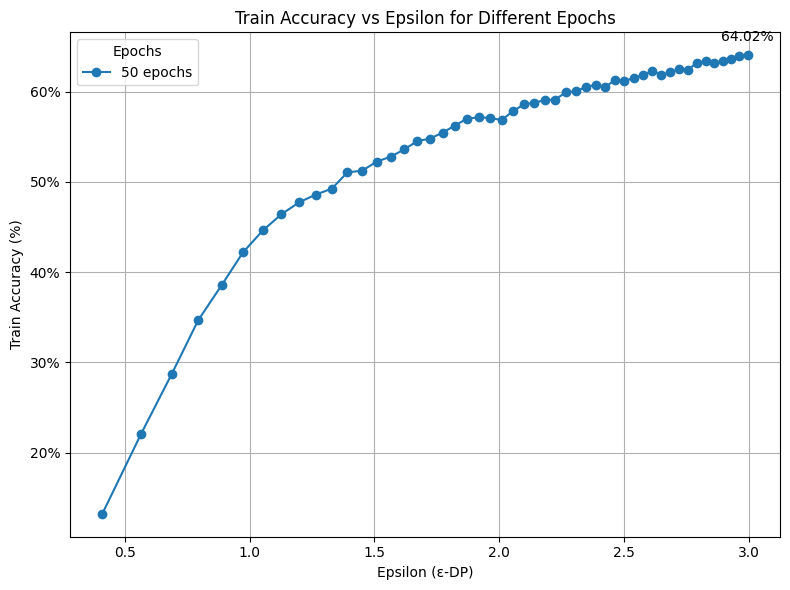

In [23]:
import matplotlib.pyplot as plt

# Function to plot train accuracy vs epsilon for different epoch values
def plot_train_accuracy_vs_epsilon(results, epochs_list, epsilon_list):
    plt.figure(figsize=(8, 6))

    # Loop over the number of epochs
    for epoch_idx, num_epochs in enumerate(epochs_list):
        epsilons = []
        train_accuracies = []

        # Loop over the different epsilon values for this epoch count
        for eps in epsilon_list:
            metrics = results[eps][epoch_idx]

            # Collect the actual epsilon values and corresponding final train accuracy
            epsilons.extend(metrics['epsilons'])  # Collect all computed epsilon values
            train_accuracies.extend([acc * 100 for acc in metrics['train_accuracy']])  # Convert accuracy to percentage

        # Plot train accuracy vs epsilon for this epoch count
        plt.plot(epsilons, train_accuracies, label=f"{num_epochs} epochs", marker='o', linestyle='-')

        # Annotate the last point with the train accuracy value
        plt.annotate(f"{train_accuracies[-1]:.2f}%",
                     (epsilons[-1], train_accuracies[-1]),
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center')

    # Label the plot
    plt.xlabel('Epsilon (ε-DP)')
    plt.ylabel('Train Accuracy (%)')
    plt.title('Train Accuracy vs Epsilon for Different Epochs')
    plt.legend(title="Epochs")
    plt.grid(True)

    # Set y-axis to percentage formatting
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))

    plt.tight_layout()
    plt.show()

# Call the function to plot the results
plot_train_accuracy_vs_epsilon(results, EPOCHS_LIST, EPSILON_LIST)


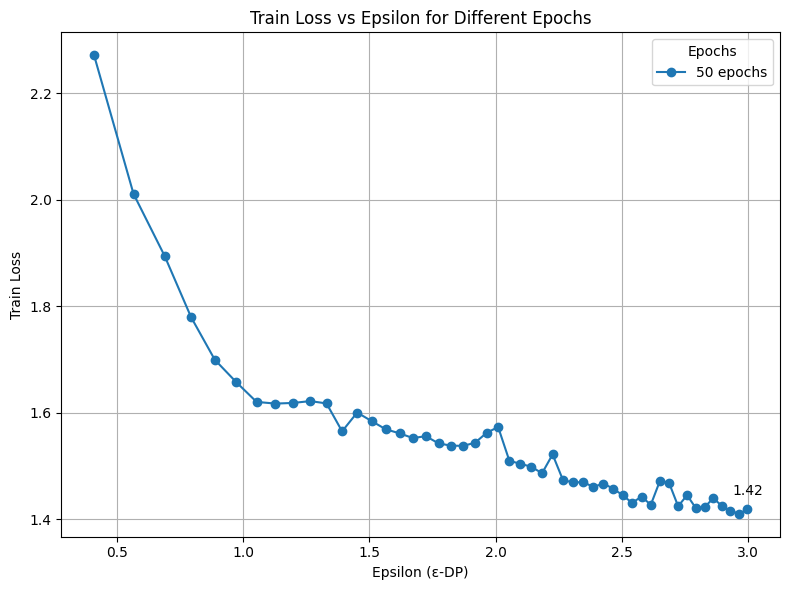

In [24]:
import matplotlib.pyplot as plt

# Function to plot train loss vs epsilon for different epoch values
def plot_train_loss_vs_epsilon(results, epochs_list, epsilon_list):
    plt.figure(figsize=(8, 6))

    # Loop over the number of epochs
    for epoch_idx, num_epochs in enumerate(epochs_list):
        epsilons = []
        train_losses = []

        # Loop over the different epsilon values for this epoch count
        for eps in epsilon_list:
            metrics = results[eps][epoch_idx]

            # Collect the actual epsilon values and corresponding final train loss
            epsilons.extend(metrics['epsilons'])  # Collect all computed epsilon values
            train_losses.extend(metrics['train_loss'])  # Collect corresponding loss values

        # Plot train loss vs epsilon for this epoch count
        plt.plot(epsilons, train_losses, label=f"{num_epochs} epochs", marker='o', linestyle='-')

        # Annotate the last point with the train loss value
        plt.annotate(f"{train_losses[-1]:.2f}",
                     (epsilons[-1], train_losses[-1]),
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center')

    # Label the plot
    plt.xlabel('Epsilon (ε-DP)')
    plt.ylabel('Train Loss')
    plt.title('Train Loss vs Epsilon for Different Epochs')
    plt.legend(title="Epochs")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function to plot the results
plot_train_loss_vs_epsilon(results, EPOCHS_LIST, EPSILON_LIST)
